Here, we perform a grid search for combinations of values for model parameters of fMTP that change the slope of the hazard function without changing sequential effects. We do this by quantifying the hazard and sequential effects and comparing them to see how they correlate.

- For now, we vary only the parameters investigated in the paper (k, c and r).
- 10 values by parameters, linearly spaced between the smallest and largest value shown in the paper (except for k, which we vary from 1 to 10 to avoid floating values for k, which the model does not accept).
- For each combination of values, simulate curves for hazard and sequential effects.
- Quantify hazard effect by the slope of the FP X RT curve
- Quantify the sequential effect by subtracting the slope for the smallest FP n-1 value from the largest FP n-1 value
- Build scatterplots of hazard and sequential effect indices;
- Check for:
    - a line (hazard and sequentia effect magnitudes correlate for the values of all parameters)
    - completely scattered points (each combination generates an effect that is unrelated to the other - this is unlikely)
    - clusters (correlation for some values, absence of correlation for others)
- Hypothesis: as this model is in part an elaboration of trace conditions, it is unlikely that it may generate hazard effects dissociated from sequential effects: in trace conditioning, the hazard effect is a product of sequential effects; in fMTP, both are the products of a common memory mechanism, and thus should correlate.
- If that is the case, a different model, such as dual-process models - e.g., as implemented by Grabenhorst et al., 2019/2021 - or a bayesian model might explain the results better.
- For now, use our current data, which will (or will not) be confirmed by a second experiment.

In [1]:
!git clone https://github.com/alex-nobre/action_foreperiod.git

Cloning into 'action_foreperiod'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 16 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (16/16), done.


In [2]:
import sys
sys.path.insert(0,'/action_foreperiod')

In [3]:
import os
os.chdir('./action_foreperiod')

In [4]:
# Import standard python packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import itertools

# Import for plotting
import matplotlib.pyplot as plt

# Import classes
from fmtp import fMTP, FPexp, FPgonogo

# Load console
%qtconsole

In [5]:
# Initialize experiment values for simulation
FP = np.arange(0.6, 1.8, 0.6)
distr = 'uni'
                                             
# create lists of model parameter values
kList=[i for i in range(1,11)] 
rList=np.linspace(-4,-1,num=10)
cList=np.linspace(0,0.0003,num=10)

# 1. Simulate experiments for discrimination task

## 1.1. Generate values

Choose values for experimental parameters and model parameters, and run experiment using FPexp function. This reproduces the methods employed to create the plots in fMTP tutorial.

In [ ]:
## Set up experiment using "FPexp"
exp = FPexp(FPs = FP, distribution = distr, tr_per_block = 150)                                           

# Simulate experiments and store in lists
simResults=[None]*(len(kList)*len(rList)*len(cList))   
    
simEl=0   
for ik in range(len(kList)):
    for ir in range(len(rList)):
        for ic in range(len(cList)):
            k=kList[ik]
            r=rList[ir]
            c=cList[ic]
            fmtp=fMTP(r,c,k)
            state_discr, state_con = exp.run_exp(fmtp)
            state_discr=state_discr[1:]
            
            # Hazard slope
            hazardLm=smf.ols(formula='prep~FP', data=state_discr).fit()
            hazardSlope=round(hazardLm.params[1],3)
            
            # Sequential effects difference of slopes
            lowFPn_1=min(np.unique(state_discr.FPn_1))
            highFPn_1=max(np.unique(state_discr.FPn_1))
            # low FP n-1
            state_lowFPn_1=state_discr[state_discr.FPn_1==lowFPn_1]
            lowSeqLm=smf.ols(formula='prep~FP',data=state_lowFPn_1).fit()
            lowSeqSlope=lowSeqLm.params[1]
            # High FP n-1
            state_highFPn_1=state_discr[state_discr.FPn_1==highFPn_1]
            highSeqLm=smf.ols(formula='prep~FP',data=state_highFPn_1).fit()
            highSeqSlope=highSeqLm.params[1]
            
            seqSlopeDiff=round(highSeqSlope-lowSeqSlope,3)
            simResults[simEl]=(hazardSlope,seqSlopeDiff)
            #print(simEl)
            simEl+=1

## 1.2. Plots

Now build several plots to examine results and some sanity checks.

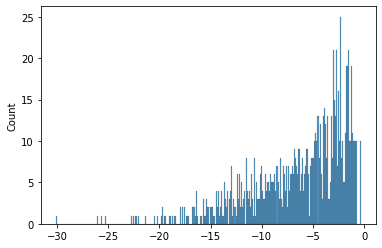

In [ ]:
# Histograms of sequential effects to check that the results make sense.
sepSimResults=list(set(zip(*simResults)))

sns.histplot(sepSimResults[1],
             binwidth=0.1)

positiveSeqEff=[ef for ef in sepSimResults[0] if ef >0] # None are positive, as expected for sequential effects.

A single plot to visualize correlation across the whole parameter space.

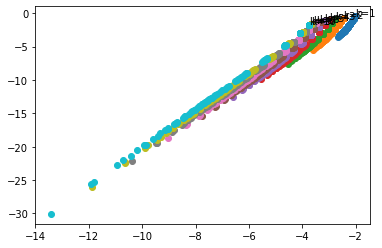

In [ ]:
# Plot on same panel with colors and annotations to distinguish data by value of k        
chunkedList=list()
chunkSize=int(len(simResults)/len(kList))

for i in range(0,len(simResults),chunkSize):
    chunkedList.append(simResults[i:i+chunkSize])

fig=plt.figure()

kSublist=0
for ik in range(len(chunkedList)):
    k=kList[kSublist]
    plotSublist=chunkedList[kSublist]
    plt.scatter(*zip(*plotSublist))
    plt.annotate(('k='+str(k)),xy=(plotSublist[-1][0],plotSublist[-1][1]+0.002))
    kSublist+=1

Now a facetted plot to disentangle the curves.

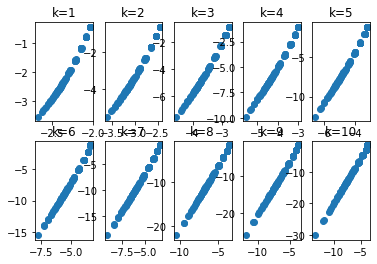

In [ ]:
# Plot by value k (each plot with all combinations of r and c)
fig,ax=plt.subplots(nrows=2,ncols=5)

kSublist=0
for row in ax:
    for col in row:
        k=kList[kSublist]
        plotSublist=chunkedList[kSublist]
        col.scatter(*zip(*plotSublist))
        col.set_title('k='+str(k))
        kSublist+=1

To assess how c influences the results (it shouldn't, according to Salet et al., 2022), we plot the results facetted by value of r, for a single value of k - here we plot them only for k=1, but we can do the rest manually.

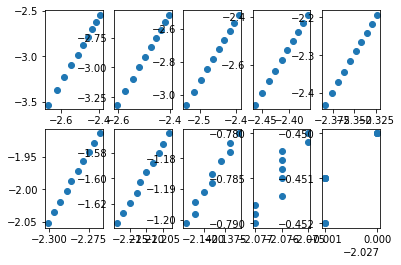

In [ ]:
# Separate plots for each r value (within a given value of k)
fig,ax=plt.subplots(nrows=2,ncols=5)
        
chunkedChunkedList=list()
chunkSize=int(len(cList))
kChunk=chunkedList[0] # change index to change value of k

for i in range(0,len(kChunk),chunkSize):
    chunkedChunkedList.append(kChunk[i:i+chunkSize])

rSublist=0
for row in ax:
    for col in row:
        plotSublist=chunkedChunkedList[rSublist]
        col.scatter(*zip(*plotSublist))
        rSublist+=1

We also compute the correlation between hazard and sequential values overall and for each value of k.

In [ ]:
np.corrcoef(*zip(*simResults))

corrList=list()
for ik in range(len(chunkedList)):
    corrSublist=chunkedList[ik]
    corrList.append(np.corrcoef(*zip(*corrSublist)))

print('\n\n')

print(corrList)




[array([[1.        , 0.99476248],
       [0.99476248, 1.        ]]), array([[1.        , 0.99599671],
       [0.99599671, 1.        ]]), array([[1.        , 0.99681835],
       [0.99681835, 1.        ]]), array([[1.        , 0.99753582],
       [0.99753582, 1.        ]]), array([[1.        , 0.99814952],
       [0.99814952, 1.        ]]), array([[1.        , 0.99866566],
       [0.99866566, 1.        ]]), array([[1.        , 0.99907907],
       [0.99907907, 1.        ]]), array([[1.      , 0.999397],
       [0.999397, 1.      ]]), array([[1.        , 0.99961816],
       [0.99961816, 1.        ]]), array([[1.       , 0.9997532],
       [0.9997532, 1.       ]])]


Since c makes little to no difference to the curves (as it should, according to fMTP) we simulate the experiments again with a fixed value of c, varying only k and r, and store them in tables.

In [ ]:
# List to store values
simResultsNoC=[None]*(len(kList)*len(rList))

simEl=0   
for ik in range(len(kList)):
    for ir in range(len(rList)):
        k=kList[ik]
        r=rList[ir]
        fmtp=fMTP(r,c,k)
        state_discr, state_con = exp.run_exp(fmtp)
        state_discr=state_discr[1:]
        
        # Hazard slope
        hazardLm=smf.ols(formula='prep~FP', data=state_discr).fit()
        hazardSlope=round(hazardLm.params[1],3)
        
        # Sequential effects difference of slopes
        lowFPn_1=min(np.unique(state_discr.FPn_1))
        highFPn_1=max(np.unique(state_discr.FPn_1))
        # low FP n-1
        state_lowFPn_1=state_discr[state_discr.FPn_1==lowFPn_1]
        lowSeqLm=smf.ols(formula='prep~FP',data=state_lowFPn_1).fit()
        lowSeqSlope=lowSeqLm.params[1]
        # High FP n-1
        state_highFPn_1=state_discr[state_discr.FPn_1==highFPn_1]
        highSeqLm=smf.ols(formula='prep~FP',data=state_highFPn_1).fit()
        highSeqSlope=highSeqLm.params[1]
        
        seqSlopeDiff=round(highSeqSlope-lowSeqSlope,3)
        simResultsNoC[simEl]=(hazardSlope,seqSlopeDiff)
        
        #print(simEl)
        simEl+=1

sepSimResultsNoC=list(set(zip(*simResultsNoC)))
hazardList=list(sepSimResultsNoC[0])
reshapedHazardList=np.reshape(hazardList, (10,10))

hazardData=pd.DataFrame(reshapedHazardList.transpose(),
                        columns=kList,
                        index=[round(item,3) for item in rList])

seqEffList=list(sepSimResultsNoC[1])
reshapedSeqEffList=np.reshape(seqEffList, (10,10))
seqEffData=pd.DataFrame(reshapedSeqEffList.transpose(),
                        columns=kList,
                        index=rList)

In [ ]:
hazardData

,1,2,3,4,5,6,7,8,9,10
-4.000,-2.543,-3.807,-5.067,-6.330,-7.576,-8.788,-9.943,-11.023,-12.011,-12.896
-3.667,-2.560,-3.840,-5.124,-6.417,-7.703,-8.960,-10.167,-11.303,-12.348,-13.289
-3.333,-2.513,-3.770,-5.033,-6.308,-7.578,-8.822,-10.019,-11.148,-12.191,-13.135
-3.000,-2.392,-3.584,-4.777,-5.976,-7.164,-8.324,-9.436,-10.482,-11.446,-12.318
-2.667,-2.193,-3.275,-4.348,-5.414,-6.459,-7.466,-8.422,-9.311,-10.124,-10.854
-2.333,-1.914,-2.846,-3.756,-4.644,-5.498,-6.306,-7.059,-7.747,-8.365,-8.912
-2.000,-1.565,-2.317,-3.035,-3.721,-4.364,-4.958,-5.498,-5.980,-6.403,-6.770
-1.667,-1.172,-1.730,-2.250,-2.735,-3.177,-3.576,-3.928,-4.235,-4.499,-4.722
-1.333,-0.780,-1.155,-1.496,-1.806,-2.082,-2.326,-2.537,-2.717,-2.868,-2.994
-1.000,-0.450,-0.674,-0.874,-1.053,-1.209,-1.344,-1.460,-1.557,-1.638,-1.705


In [ ]:
seqEffData

,1,2,3,4,5,6,7,8,9,10
-4.000000,-2.397,-3.115,-3.754,-4.361,-4.943,-5.506,-6.048,-6.566,-7.056,-7.514
-3.666667,-2.402,-3.126,-3.772,-4.388,-4.982,-5.558,-6.116,-6.651,-7.158,-7.632
-3.333333,-2.392,-3.109,-3.748,-4.355,-4.941,-5.509,-6.060,-6.588,-7.089,-7.560
-3.000000,-2.366,-3.061,-3.676,-4.255,-4.810,-5.346,-5.862,-6.356,-6.823,-7.261
-2.666667,-2.324,-2.985,-3.558,-4.090,-4.593,-5.071,-5.527,-5.958,-6.364,-6.741
-2.333333,-2.268,-2.882,-3.401,-3.871,-4.304,-4.708,-5.085,-5.436,-5.761,-6.058
-2.000000,-2.203,-2.763,-3.220,-3.620,-3.976,-4.298,-4.591,-4.857,-5.097,-5.311
-1.666667,-2.136,-2.641,-3.037,-3.369,-3.654,-3.901,-4.118,-4.308,-4.474,-4.618
-1.333333,-2.075,-2.534,-2.878,-3.156,-3.384,-3.574,-3.735,-3.870,-3.983,-4.078
-1.000000,-2.027,-2.453,-2.763,-3.005,-3.196,-3.351,-3.477,-3.579,-3.663,-3.729


# 2. Simulate experiments for go/no-go task

Here we do the same for a go/no-go task, which uses another function in the model. The crucial difference here is that traces that correspond to no-go trials have their activation values set to 0. We used the same proportion of no-go trials and, as before, the same FP values.

There is also an option to run experiments with catch trials, but none were included here.

## 2.1. Generate values

In [6]:
exp = FPgonogo(FPs = FP, distribution = distr, tr_per_block = 150, relax = 0)                                              

# create list of parameter values
kList=[i for i in range(1,11)]  #np.linspace(2,8,num=10)
#rList=np.linspace(1,4,num=10)
rList=np.linspace(-4,-1,num=10)
cList=np.linspace(0,0.0003,num=10)

# Simulate experiments and store in lists
simResults=[None]*(len(kList)*len(rList)*len(cList))   
    
simEl=0   
for ik in range(len(kList)):
    for ir in range(len(rList)):
        for ic in range(len(cList)):
            k=kList[ik]
            r=rList[ir]
            c=cList[ic]
            fmtp=fMTP(r,c,k)
            state_discr, state_con = exp.run_exp(fmtp)
            state_discr=state_discr[1:]
            
            # Hazard slope
            hazardLm=smf.ols(formula='prep~FP', data=state_discr).fit()
            hazardSlope=round(hazardLm.params[1],3)
            
            # Sequential effects difference of slopes
            lowFPn_1=min(np.unique(state_discr.FPn_1))
            highFPn_1=max(np.unique(state_discr.FPn_1))
            # low FP n-1
            state_lowFPn_1=state_discr[state_discr.FPn_1==lowFPn_1]
            lowSeqLm=smf.ols(formula='prep~FP',data=state_lowFPn_1).fit()
            lowSeqSlope=lowSeqLm.params[1]
            # High FP n-1
            state_highFPn_1=state_discr[state_discr.FPn_1==highFPn_1]
            highSeqLm=smf.ols(formula='prep~FP',data=state_highFPn_1).fit()
            highSeqSlope=highSeqLm.params[1]
            
            seqSlopeDiff=round(highSeqSlope-lowSeqSlope,3)
            simResults[simEl]=(hazardSlope,seqSlopeDiff)
            # simResults[simEl]=(hazardSlope,
            #                    round(highSeqSlope,3),
            #                    round(lowSeqSlope,3),
            #                    seqSlopeDiff)
            print(simEl)
            simEl+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

## 2.2. Plots

Same plots as before, but with go/no-go values for hazard and sequential effects

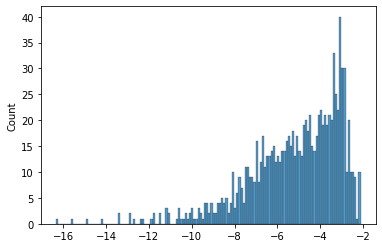

In [7]:
# Histograms of sequential effects
sepSimResults=list(set(zip(*simResults)))

sns.histplot(sepSimResults[1],
             binwidth=0.1)

positiveSeqEff=[ef for ef in sepSimResults[0] if ef >0] # None are positive

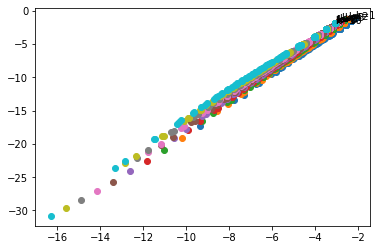

In [8]:
# Plot on same panel, but with colors and annotations to indicate value of k        
chunkedList=list()
chunkSize=int(len(simResults)/len(kList))

for i in range(0,len(simResults),chunkSize):
    chunkedList.append(simResults[i:i+chunkSize])

fig=plt.figure()

kSublist=0
for ik in range(len(chunkedList)):
    k=kList[kSublist]
    plotSublist=chunkedList[kSublist]
    plt.scatter(*zip(*plotSublist))
    plt.annotate(('k='+str(k)),xy=(plotSublist[-1][0],plotSublist[-1][1]+0.002))
    kSublist+=1

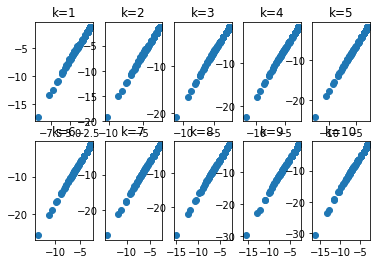

In [9]:
# Plot by value of k (each plot with all combinations of r and c)
fig,ax=plt.subplots(nrows=2,ncols=5)

kSublist=0
for row in ax:
    for col in row:
        k=kList[kSublist]
        plotSublist=chunkedList[kSublist]
        col.scatter(*zip(*plotSublist))
        col.set_title('k='+str(k))
        kSublist+=1

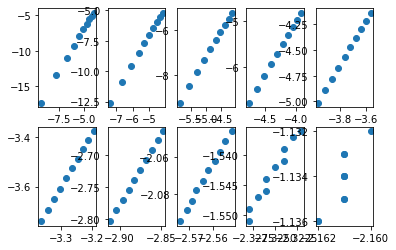

In [10]:
# Separate plots for each r value (within a given value of k)
fig,ax=plt.subplots(nrows=2,ncols=5)
        
chunkedChunkedList=list()
chunkSize=int(len(cList))
kChunk=chunkedList[0]

for i in range(0,len(kChunk),chunkSize):
    chunkedChunkedList.append(kChunk[i:i+chunkSize])

rSublist=0
for row in ax:
    for col in row:
        plotSublist=chunkedChunkedList[rSublist]
        col.scatter(*zip(*plotSublist))
        rSublist+=1

## 2.3. Correlations

In [12]:
# Compute correlation
np.corrcoef(*zip(*simResults))

corrList=list()
for ik in range(len(chunkedList)):
    corrSublist=chunkedList[ik]
    corrList.append(np.corrcoef(*zip(*corrSublist)))

corrList

## 2.4. Tables with hazard and sequential effects

In [7]:
# List to store values
simResultsNoC=[None]*(len(kList)*len(rList))

simEl=0   
for ik in range(len(kList)):
    for ir in range(len(rList)):
        k=kList[ik]
        r=rList[ir]
        fmtp=fMTP(r,c,k)
        state_discr, state_con = exp.run_exp(fmtp)
        state_discr=state_discr[1:]
        
        # Hazard slope
        hazardLm=smf.ols(formula='prep~FP', data=state_discr).fit()
        hazardSlope=round(hazardLm.params[1],3)
        
        # Sequential effects difference of slopes
        lowFPn_1=min(np.unique(state_discr.FPn_1))
        highFPn_1=max(np.unique(state_discr.FPn_1))
        # low FP n-1
        state_lowFPn_1=state_discr[state_discr.FPn_1==lowFPn_1]
        lowSeqLm=smf.ols(formula='prep~FP',data=state_lowFPn_1).fit()
        lowSeqSlope=lowSeqLm.params[1]
        # High FP n-1
        state_highFPn_1=state_discr[state_discr.FPn_1==highFPn_1]
        highSeqLm=smf.ols(formula='prep~FP',data=state_highFPn_1).fit()
        highSeqSlope=highSeqLm.params[1]
        
        seqSlopeDiff=round(highSeqSlope-lowSeqSlope,3)
        simResultsNoC[simEl]=(hazardSlope,seqSlopeDiff)
        
        print(simEl)
        simEl+=1

sepSimResultsNoC=list(set(zip(*simResultsNoC)))
hazardList=list(sepSimResultsNoC[0])
reshapedHazardList=np.reshape(hazardList, (10,10))

hazardData=pd.DataFrame(reshapedHazardList.transpose(),
                        columns=kList,
                        index=[round(item,3) for item in rList])

seqEffList=list(sepSimResultsNoC[1])
reshapedSeqEffList=np.reshape(seqEffList, (10,10))
seqEffData=pd.DataFrame(reshapedSeqEffList.transpose(),
                        columns=kList,
                        index=[round(item,3) for item in rList])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Now we run pairwise comparisons across the sequential effects list to identify values that have approximately the same magnitude of sequential effects (difference between them < 0.03). Then, we simulate the experiments using corresponding parameter values and plot them all together.

AttributeError: ignored

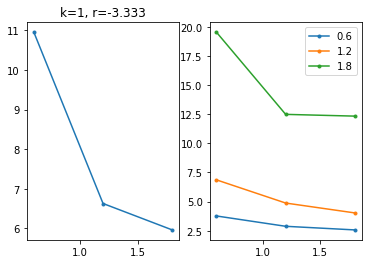

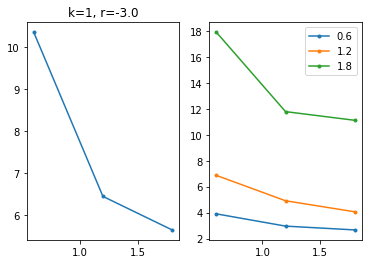

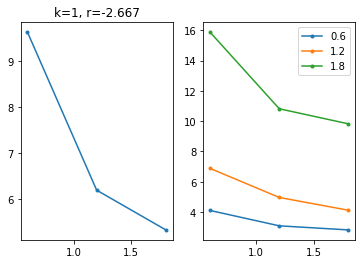

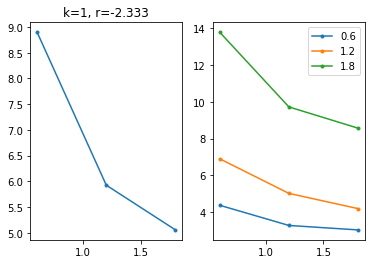

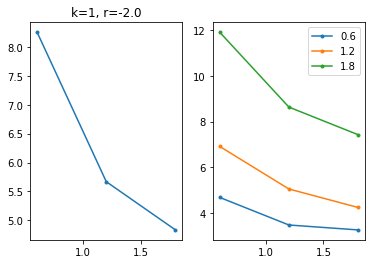

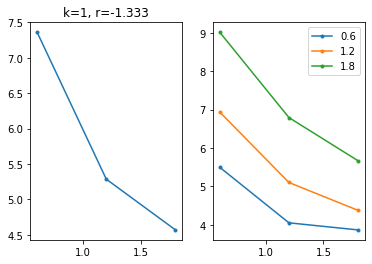

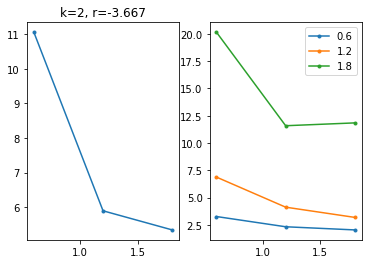

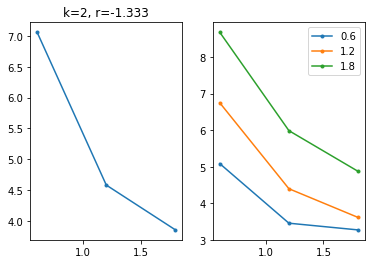

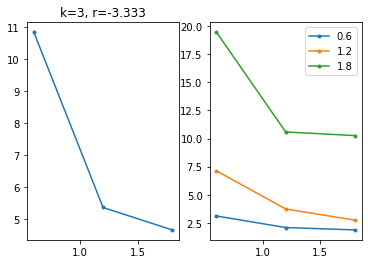

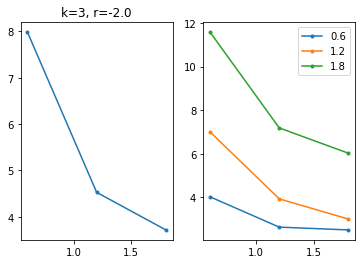

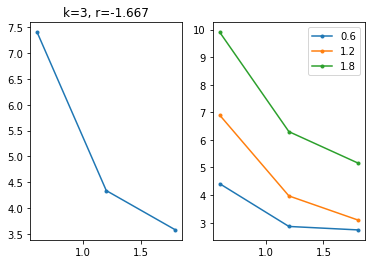

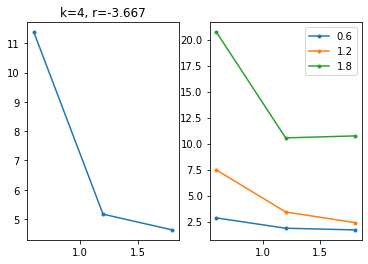

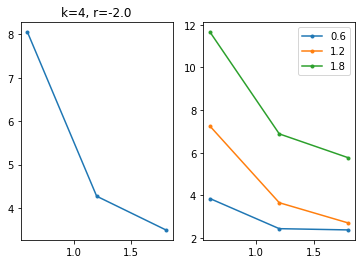

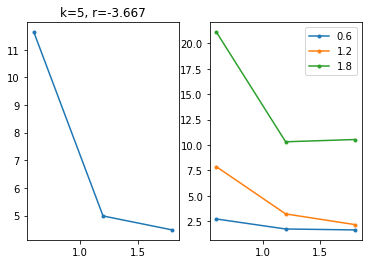

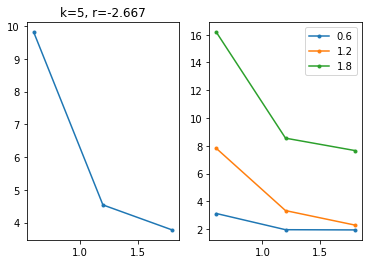

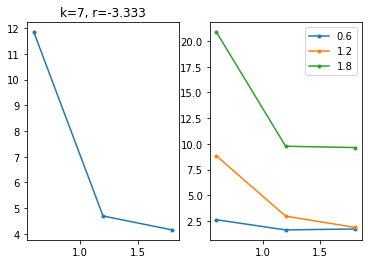

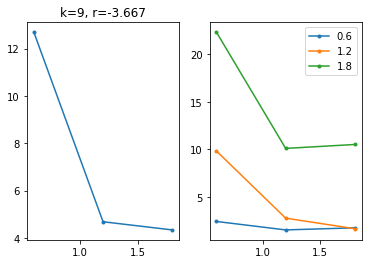

<Figure size 432x288 with 0 Axes>

In [10]:
paramPairs=list(itertools.product(kList, [round(item,3) for item in rList]))

paramCombinations=list(itertools.combinations(paramPairs, 2))

abs(seqEffData.loc[paramCombinations[4789][0][1],paramCombinations[4789][0][0]]-seqEffData.loc[paramCombinations[4789][1][1],paramCombinations[4789][1][0]])<0.03

relParams={pair[0]:pair[1] for pair in paramCombinations if 
              abs(seqEffData.loc[pair[0][1],pair[0][0]] - seqEffData.loc[pair[1][1],pair[1][0]]) < 0.03}

len(relParams)

# Simulate experiment
for params in relParams:
    k=params[0]
    r=params[1]
    fmtp=fMTP(r,c,k)
    state_discr, state_con = exp.run_exp(fmtp)
    state_discr=state_discr[1:]
    mean_state=state_discr.groupby(['FP']).mean().reset_index()
    f, ax = plt.subplots(1,2)
    ax[0].plot(mean_state.FP, mean_state.prep, '.-')
    ax[0].set_title('k='+str(k)+', r='+str(r))
    
    mean_state = state_discr.groupby(['FP', 'FPn_1']).mean().reset_index()        
    for iFP in np.unique(mean_state.FPn_1):
        state_n1 = mean_state[mean_state.FPn_1 == iFP]
        ax[1].plot(state_n1.FP, state_n1.prep, '.-')
    ax[1].legend([0.6, 1.2, 1.8])




# Build plots
fig=plt.figure(constrained_layout=True)
subfigs=fig.subfigures(4,5)

subfigsCoords=list(itertools.product([0,1,2,3],[0,1,2,3,4]))

iSubfig=0
for params in relParams:
    # Simulate experiment
    k=params[0]
    r=params[1]
    fmtp=fMTP(r,c,k)
    state_discr, state_con = exp.run_exp(fmtp)
    state_discr=state_discr[1:]
    
    # Create subplots within subfigures
    ax=subfigs[subfigsCoords[iSubfig]].subplots(1,2,sharey=True)
    
    mean_state=state_discr.groupby(['FP']).mean().reset_index()
    ax[0].plot(mean_state.FP, mean_state.prep, '.-')
    #ax[0].set_title('k='+str(k)+', r='+str(r))
    
    mean_state = state_discr.groupby(['FP', 'FPn_1']).mean().reset_index()        
    for iFP in np.unique(mean_state.FPn_1):
        state_n1 = mean_state[mean_state.FPn_1 == iFP]
        ax[1].plot(state_n1.FP, state_n1.prep, '.-')
    ax[1].legend([0.6, 1.2, 1.8])
    subfigs[subfigsCoords[iSubfig]].suptitle('k='+str(k)+', r='+str(r))
    iSubfig+=1